# Analyzing cleaned_queries.json

Source: unknown
What: Dataset of SparQL queries with some context and descriptions. Context and descriptions can be irrelevant.

## Preparing the dataset for "real" condition usage

In [1]:
import json
import numpy as np
import pandas as pd
import re

In [2]:
with open("./datasets/cleaned_queries/cleaned_queries.json", 'r') as f:
    cleaned_queries = json.load(f)

df_cleaned_queries = pd.DataFrame(cleaned_queries)
df_cleaned_queries = pd.concat([df_cleaned_queries.drop(['metadata'], axis=1), df_cleaned_queries['metadata'].apply(pd.Series)], axis=1)
df_cleaned_queries.head()

,query,description,context
0,SELECT ?property ?propertyType ?propertyLabel ...,Wikidata properties in numerical order,Counting stuff on Wikidata\nAll Wikidata prope...
1,SELECT ?id ?idLabel ?idDescription ?new{\n?id ...,Wikidata properties excluding external IDs,Counting stuff on Wikidata\nVariation of the a...
2,SELECT (COUNT(?article) AS ?count)\nWHERE {\n?...,,Counting stuff on Wikidata\nCount of scientifi...
3,SELECT (COUNT(DISTINCT ?article) AS ?count)\nW...,Count of fictional characters,Counting stuff on Wikidata\nCount of fictional...
4,SELECT (COUNT(?item) AS ?count)\nWHERE { ?item...,Count of items with coordinate locations,Counting stuff on Wikidata\nCount of items wit...


## Analyzing as a whole

### Caracteristics of the dataset

In [3]:
df_cleaned_queries.describe()

,query,description,context
count,6739,6739,6739
unique,2779,2249,731
top,SELECT ?twit ?item ?itemLabel ?itemDescription...,,
freq,12,3197,2087


There is **3894 rows** that have another identical row in the dataset. The first row in the dataset of such duplicated row is not counted in the duplicated rows. So there is 3894 identical rows that waste memory and computing power. It's a whopping **57.8%** of the dataset. *More than half*.

In [4]:
print(df_cleaned_queries.duplicated().sum())
df_cleaned_queries.duplicated().sum()/len(df_cleaned_queries)

3894


0.5778305386555869

*To make sure they are really identical...*
Looking here at all queries that are identical to the very first row of the dataset.

In [8]:
all_rows_same_than_0 = df_cleaned_queries.loc[df_cleaned_queries['query'] == df_cleaned_queries['query'].iat[0]]
for i in all_rows_same_than_0['query'][:3]:
    print(i)
    print('-'*50)

SELECT ?property ?propertyType ?propertyLabel ?propertyDescription WHERE {
?property wikibase:propertyType ?propertyType .
SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
} ORDER BY ASC(xsd:integer(STRAFTER(STR(?property), 'P')))
--------------------------------------------------
SELECT ?property ?propertyType ?propertyLabel ?propertyDescription WHERE {
?property wikibase:propertyType ?propertyType .
SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
} ORDER BY ASC(xsd:integer(STRAFTER(STR(?property), 'P')))
--------------------------------------------------
SELECT ?property ?propertyType ?propertyLabel ?propertyDescription WHERE {
?property wikibase:propertyType ?propertyType .
SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
} ORDER BY ASC(xsd:integer(STRAFTER(STR(?property), 'P')))
--------------------------------------------------


All rows are **not null**. But are they empty?

In [9]:
df_cleaned_queries.isna().sum()

query          0
description    0
context        0
dtype: int64

Some rows of context and description are empty strings. But this is not a problem. Looking at the use case for the LLM, it would be maybe interesting when generating the prompt. To include them only if they are not empty. The reassuring thing is that every queries is not null.

In [10]:
print((df_cleaned_queries['query'].values == '').sum())
print((df_cleaned_queries['context'].values == '').sum())
print((df_cleaned_queries['description'].values == '').sum())

0
2087
3197


### Removing all identical rows.
Note: that some row can have identical description or context, or even queries as long as one of the field is different.

In [11]:
df_no_duplicated_rows = df_cleaned_queries.drop_duplicates(keep="first", ignore_index=True)

Question: is there still empty context and description fields when removing duplicates?

Answer: Yes, but a lot less empty descriptions.

In [12]:
print((df_no_duplicated_rows['query'].values == '').sum())
print((df_no_duplicated_rows['context'].values == '').sum())
print((df_no_duplicated_rows['description'].values == '').sum())

0
2072
499


## Analyzing Queries

The goal is to find outliers. There are too many rows for a manual inspection even though it could be doable.

### Caracteristics

In [13]:
df_no_duplicated_rows["query"].describe()

count                                                  2845
unique                                                 2779
top       SELECT DISTINCT ?author ?authorLabel ?image ?c...
freq                                                      3
Name: query, dtype: object

In [14]:
df_no_duplicated_rows['query'].str.len().describe()

count    2845.000000
mean      440.365905
std       314.802172
min        43.000000
25%       246.000000
50%       350.000000
75%       541.000000
max      4423.000000
Name: query, dtype: float64

### Box Plot

There is a lot of "outliers" for matplotlib. The definition can be found here https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html.

An outlier in the box plot is something outside of \[Q1-1.5*IQR;Q3+1.5*IQR\] and IQR = Q3 - Q1.

Question 1: How many outliers there are?\
Question 2: What are the caracteristics of the outliers? What are they querying?\
Question 3: What do we do with them?

<Axes: >

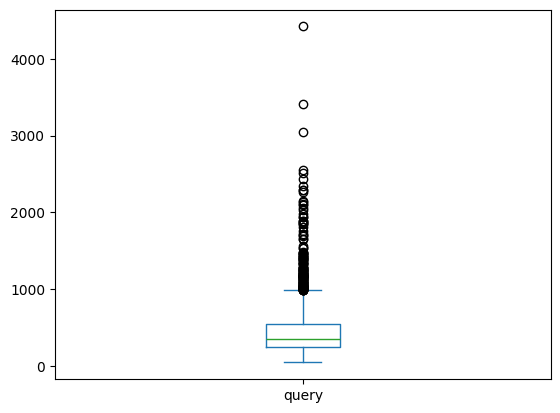

In [15]:
df_no_duplicated_rows['query'].apply(lambda x: len(x)).plot(kind="box")

Question 1: How many outliers there are?\
Answer: 142. 140 of them are unique.

In [16]:
Q1 = df_no_duplicated_rows['query'].str.len().quantile(0.25)
Q3 = df_no_duplicated_rows['query'].str.len().quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5
query_outliers = df_no_duplicated_rows[(df_no_duplicated_rows['query'].str.len() < Q1 - threshold * IQR) | (df_no_duplicated_rows['query'].str.len() > Q3 + threshold * IQR)]
query_outliers['query'].str.len().describe()

count     142.000000
mean     1405.683099
std       508.029225
min       988.000000
25%      1078.500000
50%      1220.000000
75%      1483.750000
max      4423.000000
Name: query, dtype: float64

In [17]:
sorted_query_outliers = query_outliers.sort_values(by='query', key=lambda x: x.str.len())
sorted_query_outliers.head()

,query,description,context
2136,SELECT\n?article\n(SUM(?male) AS ?count_males)...,Comparing gender statistics about people cited...,
1047,select distinct ?groupLabel (?groupLabel as ?l...,Graves with grave pictures of people buried in...,
2526,SELECT DISTINCT ?item ?itemLabel (COUNT(DISTIN...,Italian parliamentarians and ministers aged be...,
1267,SELECT ?person ?personLabel ?LibrisXL (?articl...,People at Svensktoversattarlexikon missing a L...,
1046,select distinct ?groupLabel (?groupLabel as ?l...,Graves with no grave pictures of people buried...,


Question 2: What are the caracteristics of the outlier? What are they querying?\
Answer: One caracteristic is that if we look at the samples below, all use BIND. Some uses WITH and UNION. They are queries with sub queries for the most part. An interesting note, is that they are commented which can maybe help the LLM understand better. They also involve some kind of computation on the data retrieved.

Question 3: What do we do with them?\
Answer: The samples of these outliers seems to be coherent SparQL queries. If we look at the coherency only, there is no reason to remove them. But, we are using LLMs to generate prompts based on the query, context and description. A query (same for context and description) too long can be too large for the context of the LLM (LLAMA2's context size is 2048 tokens).

Using https://belladoreai.github.io/llama-tokenizer-js/example-demo/build/, the last sample below (the longest query in the dataset), uses 2433 tokens and 4423 characters. Surpassing LLAMA2's context size. Though, it should be noted that the before the last query consist of 3408 characters and 1711 tokens. Estimating that we need ~200 tokens in prompt, it is fine. If the context and description are not too large.

For this particular sample (the second to last), it works.

Then, we only truly have to remove the longest one, because it doesn't fit the context of LLAMA2 and can generate wrong data.

In [26]:
samples_index = [0, 25, 50, 75, 100, 125, 140, 141]
for s_index in samples_index:
    sample = sorted_query_outliers['query'].iat[s_index]
    print('-'*20 + 'vvv[strlen=' + str(len(sample)) + "]vvv" + '-'*20)
    print(sample)

--------------------vvv[strlen=988]vvv--------------------
SELECT
?article
(SUM(?male) AS ?count_males)
(SUM(?female) AS ?count_females)
(SUM(?nonbinary) AS ?count_nonbinary)
(COUNT(*) AS ?count)
(ROUND(100 * ?count_females / (?count_females + ?count_males + ?count_nonbinary)) AS ?share_females)
(ROUND(100 * ?count_nonbinary / (?count_females + ?count_males + ?count_nonbinary)) AS ?share_nonbinary)
(ROUND(100 * ?count_males / (?count_females + ?count_males + ?count_nonbinary)) AS ?share_males)
{
VALUES ?article {
"Anthropology"
"Philosophy"
"Economics"
"Sociology"
"Demography"
}
SERVICE wikibase:mwapi {
bd:serviceParam wikibase:endpoint "en.wikipedia.org";
wikibase:api "Generator";
mwapi:generator "links";
mwapi:titles ?article;.
?item wikibase:apiOutputItem mwapi:item.
}
FILTER BOUND (?item)
?item wdt:P31 wd:Q5 .
?item wdt:P21 ?gender .
BIND(IF(?gender IN(wd:Q6581097, wd:Q2449503), 1, 0) AS ?male )
BIND(IF(?gender IN(wd:Q6581072, wd:Q1052281), 1, 0 ) AS ?female)
BIND(IF(?gender = wd:Q

## Analyzing Context

### Box Plot

Just like the "query" field there is a lot of outliers.\
Note: We don't consider context field that are just empty strings in the outlier analysis. This gives a little more "room" and there is a lot of empty strings that would skew the analysis.

It is obvious that we should cut the any context that is longer to a threshold. This threshold could be dynamic between query, context and description. As long as it fit into the context size, it should be fine.

But let's explore a bit what all of this is made of.

<Axes: >

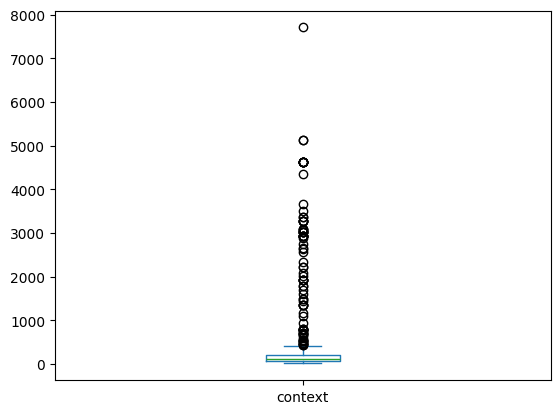

In [28]:
df_no_duplicated_rows['context'].loc[df_no_duplicated_rows['context'].str.len() > 0].apply(lambda x: len(x)).plot(kind="box")

In [29]:
Q1 = df_no_duplicated_rows['context'].loc[df_no_duplicated_rows['context'].str.len() > 0].str.len().quantile(0.25)
Q3 = df_no_duplicated_rows['context'].loc[df_no_duplicated_rows['context'].str.len() > 0].str.len().quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5
context_outlier = df_no_duplicated_rows[(df_no_duplicated_rows['context'].str.len() < Q1 - threshold * IQR) | (df_no_duplicated_rows['context'].str.len() > Q3 + threshold * IQR)].loc[df_no_duplicated_rows['context'].str.len() > 0]
context_outlier['context'].str.len().describe()

count      90.000000
mean     2271.966667
std      1479.446757
min       426.000000
25%       796.250000
50%      2047.500000
75%      3083.250000
max      7710.000000
Name: context, dtype: float64

After manual inspection. A lot of the context element are lessons material. But also, a significant bulk of characters are just because of the markup language.

It contains relevant (and not so relevant) information  but we should at least remove all markup.

In [29]:
# context_outlier_no_markup.to_excel("context_outlier.xlsx")

In [32]:
samples_index = [0,1,2,5]
for s_index in samples_index:
    print('-'*50)
    print(context_outlier['context'].iloc[s_index])
    print()

--------------------------------------------------
Timeline
'''[http://histropedia.com/showcase/wikidata-viewer.html?q=SELECT%20?personLabel%20?person%20?enwp%20(SAMPLE(?image)%20AS%20?img)%20?birthdate%20?birthdatePrecision%20?deaddate%20?deaddatePrecision%20WHERE%20%7B%0AVALUES%20?person%20%7Bwd:Q234816%20wd:Q62530%20wd:Q234421%20wd:Q231549%20wd:Q246135%20wd:Q101638%20wd:Q15994440%20wd:Q230120%20wd:Q260378%20wd:Q1377789%20wd:Q5322139%20wd:Q254858%20wd:Q6766368%20wd:Q7259%20wd:Q4949015%20wd:Q47152%20wd:Q272077%20wd:Q198984%20wd:Q1284275%20wd:Q651786%20wd:Q460152%20wd:Q230507%20wd:Q3263690%20wd:Q270855%20wd:Q5362637%20wd:Q23620545%20wd:Q27728558%20wd:Q17892%20wd:Q36322%20wd:Q57286%20wd:Q18576000%20wd:Q45410399%20wd:Q7207%7D%20.%0A?enwp%20schema:about%20?person%20;%20schema:isPartOf%20%3Chttps://en.wikipedia.org/%3E%0AOPTIONAL%7B%20?person%20wdt:P18%20?image%20%7D%0AOPTIONAL%7B%20?person%20p:P569/psv:P569%20?birthdateStatementNode%20.%0A?birthdateStatementNode%20wikibase:timeValue%20?bi

### Removing markup from context

In [33]:
compiled = re.compile("<\/?[a-zA-z?;=\"' ]*>|<.+[\W]>", flags=0)
compiled2 = re.compile("(?:class|colspan|style|rowspan)=\".+\"", flags=0)
df_no_duplicate_2_no_markup = df_no_duplicated_rows.copy()
df_no_duplicate_2_no_markup["context"] = df_no_duplicate_2_no_markup['context'].apply(lambda x: compiled2.sub(' ', compiled.sub(' ', x)).strip().replace('\n\n', '\n'))
df_no_duplicate_2_no_markup.head()

,query,description,context
0,SELECT ?property ?propertyType ?propertyLabel ...,Wikidata properties in numerical order,Counting stuff on Wikidata\nAll Wikidata prope...
1,SELECT ?id ?idLabel ?idDescription ?new{\n?id ...,Wikidata properties excluding external IDs,Counting stuff on Wikidata\nVariation of the a...
2,SELECT (COUNT(?article) AS ?count)\nWHERE {\n?...,,Counting stuff on Wikidata\nCount of scientifi...
3,SELECT (COUNT(DISTINCT ?article) AS ?count)\nW...,Count of fictional characters,Counting stuff on Wikidata\nCount of fictional...
4,SELECT (COUNT(?item) AS ?count)\nWHERE { ?item...,Count of items with coordinate locations,Counting stuff on Wikidata\nCount of items wit...


Even after removing markup language in the context we still have some outliers and big ones too. Let's just cut them off and replace them with an empty string. All context that are above 1000 characters will be replaced.

<Axes: >

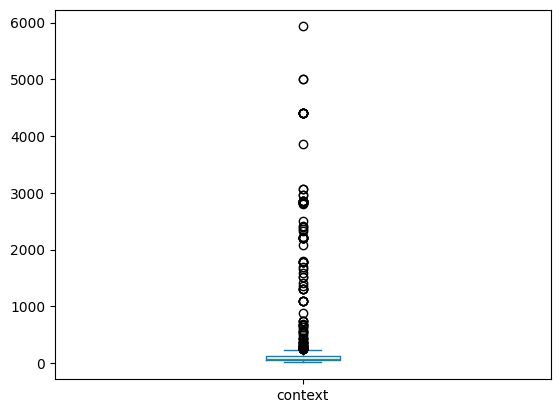

In [34]:
df_no_duplicate_2_no_markup['context'].loc[df_no_duplicate_2_no_markup['context'].str.len() > 0].apply(lambda x: len(x)).plot(kind="box")

## Analyzing Description

### Box Plot

Let's do it again for descriptions.

There's not much outlier, so we can manually inspect it and decide what to do with it.

In [35]:
df_no_duplicate_2_no_markup.describe()

,query,description,context
count,2845,2845,2845
unique,2779,2249,731
top,SELECT DISTINCT ?author ?authorLabel ?image ?c...,,
freq,3,499,2072


<Axes: >

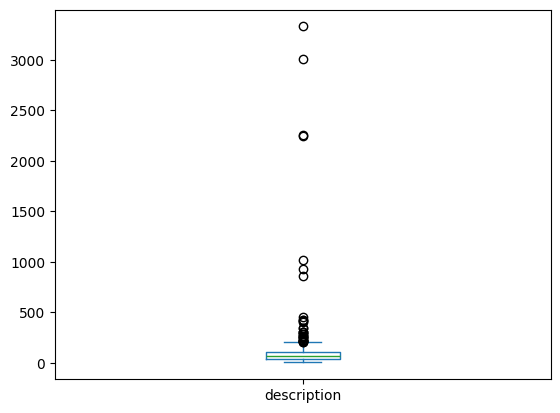

In [36]:
df_no_duplicate_2_no_markup['description'].loc[df_no_duplicate_2_no_markup['description'].str.len() > 0].apply(lambda x: len(x)).plot(kind="box")

In [37]:
Q1 = df_no_duplicate_2_no_markup['description'].loc[df_no_duplicate_2_no_markup['description'].str.len() > 0].str.len().quantile(0.25)
Q3 = df_no_duplicate_2_no_markup['description'].loc[df_no_duplicate_2_no_markup['description'].str.len() > 0].str.len().quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5
description_outlier = df_no_duplicate_2_no_markup[(df_no_duplicate_2_no_markup['description'].str.len() < Q1 - threshold * IQR) | (df_no_duplicate_2_no_markup['description'].str.len() > Q3 + threshold * IQR)].loc[df_no_duplicate_2_no_markup['description'].str.len() > 0]
description_outlier['description'].str.len().describe()

count      32.000000
mean      654.500000
std       831.639073
min       209.000000
25%       243.250000
50%       300.500000
75%       432.000000
max      3329.000000
Name: description, dtype: float64

In [41]:
# description_outlier.to_excel("description_outlier.xlsx")

After inspection, the biggest outliers contains long URLs. Let's just deleted them as they not of big relevance to the task.

In [38]:
compiled = re.compile("https:[a-zA-Z%:./#_0-9]+", flags=0)
df_description_no_markup = df_no_duplicate_2_no_markup.copy()
df_description_no_markup["description"] = df_description_no_markup['description'].apply(lambda x: compiled.sub(' ', x).strip().replace('\n\n', '\n'))
df_description_no_markup.head()

,query,description,context
0,SELECT ?property ?propertyType ?propertyLabel ...,Wikidata properties in numerical order,Counting stuff on Wikidata\nAll Wikidata prope...
1,SELECT ?id ?idLabel ?idDescription ?new{\n?id ...,Wikidata properties excluding external IDs,Counting stuff on Wikidata\nVariation of the a...
2,SELECT (COUNT(?article) AS ?count)\nWHERE {\n?...,,Counting stuff on Wikidata\nCount of scientifi...
3,SELECT (COUNT(DISTINCT ?article) AS ?count)\nW...,Count of fictional characters,Counting stuff on Wikidata\nCount of fictional...
4,SELECT (COUNT(?item) AS ?count)\nWHERE { ?item...,Count of items with coordinate locations,Counting stuff on Wikidata\nCount of items wit...


<Axes: >

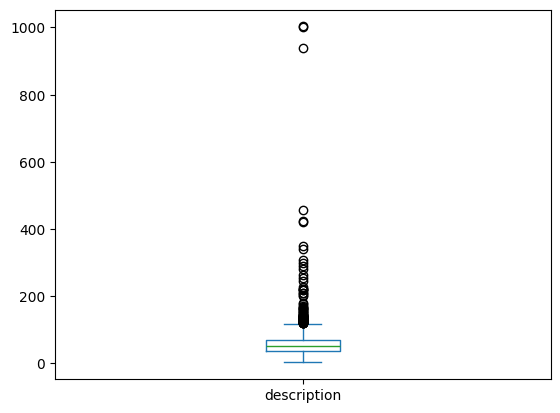

In [39]:
df_description_no_markup['description'].loc[df_description_no_markup['description'].str.len() > 0].apply(lambda x: len(x)).plot(kind="box")

# Pre-generating prompts

In this section we will pre-generate all prompts. This will also us to tokenize them and see if they fit in the context size. We use LLAMA2 tokenizer.

In [51]:
import http.client

SERVER_ADDR = "127.0.0.1"
SERVER_PORT = "8080"
SERVER_COMPLETION_ENDPOINT = "/tokenize"
POST_COMPLETION_HEADERS = {"Content-Type":"application/json"}
SYSTEM_PROMPT = "<<SYS>>This is a conversation between User and Llama, a friendly chatbot. Llama is helpful, kind, honest, good at writing, and never fails to answer any requests immediately and with precision.<</SYS>>\n"

def query(parameters):
    body_json = json.dumps(parameters)
    connection = http.client.HTTPConnection(f"{SERVER_ADDR}:{SERVER_PORT}")
    connection.request(method="POST",
            url=SERVER_COMPLETION_ENDPOINT,
            headers=POST_COMPLETION_HEADERS, 
            body=body_json)

    response = connection.getresponse()

    if response.status != 200:
        return False
    
    answer = response.read()
    answer_dict = json.loads(answer)
    return answer_dict['tokens']

def row_data_into_text(row):
  return f"QUERY=\"{row['query']}\" DESCRIPTION=\"{row['description']}\" CONTEXT=\"{row['context']}\""

def basic_prompt(sys_prompt, query):
  return f"""<s>[INST] {sys_prompt}
{row_data_into_text(query)}

User: Read QUERY, DESCRIPTION and CONTEXT. There is a machine capable of writing the given QUERY if we ask it the right prompt. Please do not include parts of QUERY in your answers. Give a list of 3 prompts that would give QUERY. [\INST]
Llama:"""

In [50]:
df_description_no_markup.describe()

,query,description,context
count,2845,2845,2845
unique,2779,2248,731
top,SELECT DISTINCT ?author ?authorLabel ?image ?c...,,
freq,3,499,2072


In [53]:
df_with_prompts = df_description_no_markup.copy()
df_with_prompts['prompt'] = df_with_prompts.apply(lambda x: basic_prompt(SYSTEM_PROMPT, x), axis=1)
df_with_prompts.describe()

,query,description,context,prompt
count,2845,2845,2845,2845
unique,2779,2248,731,2845
top,SELECT DISTINCT ?author ?authorLabel ?image ?c...,,,<s>[INST] <<SYS>>This is a conversation betwee...
freq,3,499,2072,1


In [55]:
for p in df_with_prompts['prompt'][:2]:
    print('-'*50)
    print(p)

--------------------------------------------------
<s>[INST] <<SYS>>This is a conversation between User and Llama, a friendly chatbot. Llama is helpful, kind, honest, good at writing, and never fails to answer any requests immediately and with precision.<</SYS>>

QUERY="SELECT ?property ?propertyType ?propertyLabel ?propertyDescription WHERE {
?property wikibase:propertyType ?propertyType .
SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
} ORDER BY ASC(xsd:integer(STRAFTER(STR(?property), 'P')))" DESCRIPTION="Wikidata properties in numerical order" CONTEXT="Counting stuff on Wikidata
All Wikidata properties with label and description, ordered numerically
Adapted from one of the Query Service Examples"

User: Read QUERY, DESCRIPTION and CONTEXT. There is a machine capable of writing the given QUERY if we ask it the right prompt. Please do not include parts of QUERY in your answers. Give a list of 3 prompts that would give QUERY. [\INST]
Llama:
--------

In [56]:
df_with_prompts['num_tokens'] = df_with_prompts.apply(lambda x: len(query({"content": x['prompt']})), axis=1)
df_with_prompts.describe()

,num_tokens
count,2845.000000
mean,377.100879
std,190.416213
min,168.000000
25%,271.000000
50%,323.000000
75%,415.000000
max,2805.000000


In [67]:
df_with_prompts[['prompt', 'num_tokens']][:5]

,prompt,num_tokens
0,<s>[INST] <<SYS>>This is a conversation betwee...,267
1,<s>[INST] <<SYS>>This is a conversation betwee...,296
2,<s>[INST] <<SYS>>This is a conversation betwee...,197
3,<s>[INST] <<SYS>>This is a conversation betwee...,203
4,<s>[INST] <<SYS>>This is a conversation betwee...,186


The tokenized prompts are between [168 and 2805] (excluding BOS token, so consider adding +1), which is small enough for LLAMA2's context size of 4096. There is no need to limit the size of any prompt.

## What have we done.

### Whole dataset

We removed all identical rows. And just kept one row of such identical rows.\
6739 -> 2845 rows

### Queries

Nothing.

### Context

We removed irrelevant markup.\
2844 -> 2844 rows.

### Description

We removed irrelevant URLs.\
2844 -> 2844 rows.

## Tokenization

Computed the tokenize prompt to see the size of the prompt. It will prove useful if there is limitation in the context size of the model.

## Export of the data

In [72]:
final_queries_json = df_with_prompts.to_json()

with open("./outputs/final_queries_v1.1.json", "w") as f:
    f.write(final_queries_json)